In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
import torchvision.models as models
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import requests
from PIL import Image
from io import BytesIO

import copy

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


numb_batch = 128

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
root ='./'
train_data  = torchvision.datasets.MNIST(  root, train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST( root, train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

In [ ]:
examples = enumerate( train_dl )
batch_idx, (example_data, example_targets) = next(examples)
print(  example_data.shape )

torch.Size([128, 1, 28, 28])


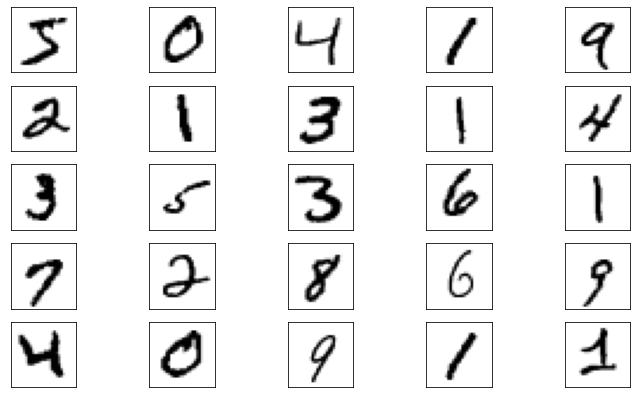

In [ ]:
plt.figure(figsize=(12,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i][0][0], cmap=plt.cm.binary)
    #plt.title( train_data[i] )
plt.show()


In [ ]:
model = models.resnet18(pretrained=False)

model.conv1 = nn.Conv2d( 1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [ ]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = model.to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  97.87999725341797
Epoch: 1 Accuracy : 97.87999725341797 %
Saving Best Model with Accuracy:  98.55000305175781
Epoch: 2 Accuracy : 98.55000305175781 %
Epoch: 3 Accuracy : 98.5199966430664 %
Saving Best Model with Accuracy:  98.61000061035156
Epoch: 4 Accuracy : 98.61000061035156 %
Epoch: 5 Accuracy : 98.33999633789062 %
Epoch: 6 Accuracy : 98.58000183105469 %
Saving Best Model with Accuracy:  99.02999877929688
Epoch: 7 Accuracy : 99.02999877929688 %
Epoch: 8 Accuracy : 98.9000015258789 %
Saving Best Model with Accuracy:  99.13999938964844
Epoch: 9 Accuracy : 99.13999938964844 %
Epoch: 10 Accuracy : 99.0 %
Epoch: 11 Accuracy : 99.02999877929688 %
Epoch: 12 Accuracy : 98.81999969482422 %
Epoch: 13 Accuracy : 98.70999908447266 %
Epoch: 14 Accuracy : 98.94000244140625 %
Epoch: 15 Accuracy : 99.0999984741211 %
Epoch: 16 Accuracy : 99.04000091552734 %
Saving Best Model with Accuracy:  99.19000244140625
Epoch: 17 Accuracy : 99.19000244140625 %
Epoch: 18 Accura

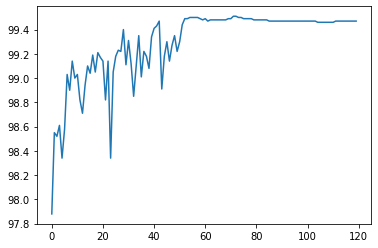

In [ ]:
train_ResNet = train(120, device=device)